In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [4]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
bq_assistant.list_tables()

Using Kaggle's public dataset BigQuery integration.


['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [4]:
# original query from https://www.kaggle.com/code/d4isdavid/stack-overflow-project, edited to get user_id

query = """
SELECT 
  users.id AS `User ID`,
  users.display_name AS `Display Name`, 
  users.location AS Location,
  users.reputation AS Reputation,
  COUNT(comments.id) AS Count
FROM `bigquery-public-data.stackoverflow.users` AS users
INNER JOIN `bigquery-public-data.stackoverflow.comments` AS comments
  ON users.id = comments.user_id
WHERE users.id > 0
GROUP BY users.id, users.display_name, users.location, users.reputation
ORDER BY Count DESC
LIMIT 25;
"""

# query the data
top_users = stackOverflow.query_to_pandas_safe(query, max_gb_scanned=2)
top_users

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,User ID,Display Name,Location,Reputation,Count
0,1491895,Barmar,"Arlington, MA",694414,167475
1,22656,Jon Skeet,"Reading, United Kingdom",1357603,87006
2,1048572,Bergi,None,589324,79365
3,1144035,Gordon Linoff,"New York, United States",1211186,74579
4,440558,Some programmer dude,"Malmö, Sweden",385586,69749
5,17034,Hans Passant,"Madison, WI",904625,68212
6,505088,David Heffernan,"Ulverston, United Kingdom",591216,64719
7,3832970,Wiktor Stribiżew,"Warsaw, Poland",576960,63155
8,1415724,Funk Forty Niner,None,74341,59857
9,15168,Jonathan Leffler,"Colorado, USA",707030,59119


In [5]:
top_user_ids = top_users['User ID'].tolist()  # convert to Python list

# Create a string for SQL IN clause
top_user_ids_str = ",".join(map(str, top_user_ids))

top_comments_query = f"""
SELECT post_id, user_id
FROM `bigquery-public-data.stackoverflow.comments`
WHERE user_id IN ({top_user_ids_str})
"""
top_comments = stackOverflow.query_to_pandas_safe(top_comments_query, max_gb_scanned=2)
top_comments

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,post_id,user_id
0,78631,14122
1,78601,14122
2,109979,14122
3,119655,14122
4,132755,14122
...,...,...
1586659,37520927,3832970
1586660,37525470,3832970
1586661,37533049,3832970
1586662,37589447,3832970


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

In [7]:
edges = []

# Group by post and create all pairs of users who commented on the same post
for post_id, group in top_comments.groupby('post_id'):
    users = group['user_id'].unique()
    # all combinations of 2 users
    for u1, u2 in combinations(users, 2):
        edges.append((u1, u2))


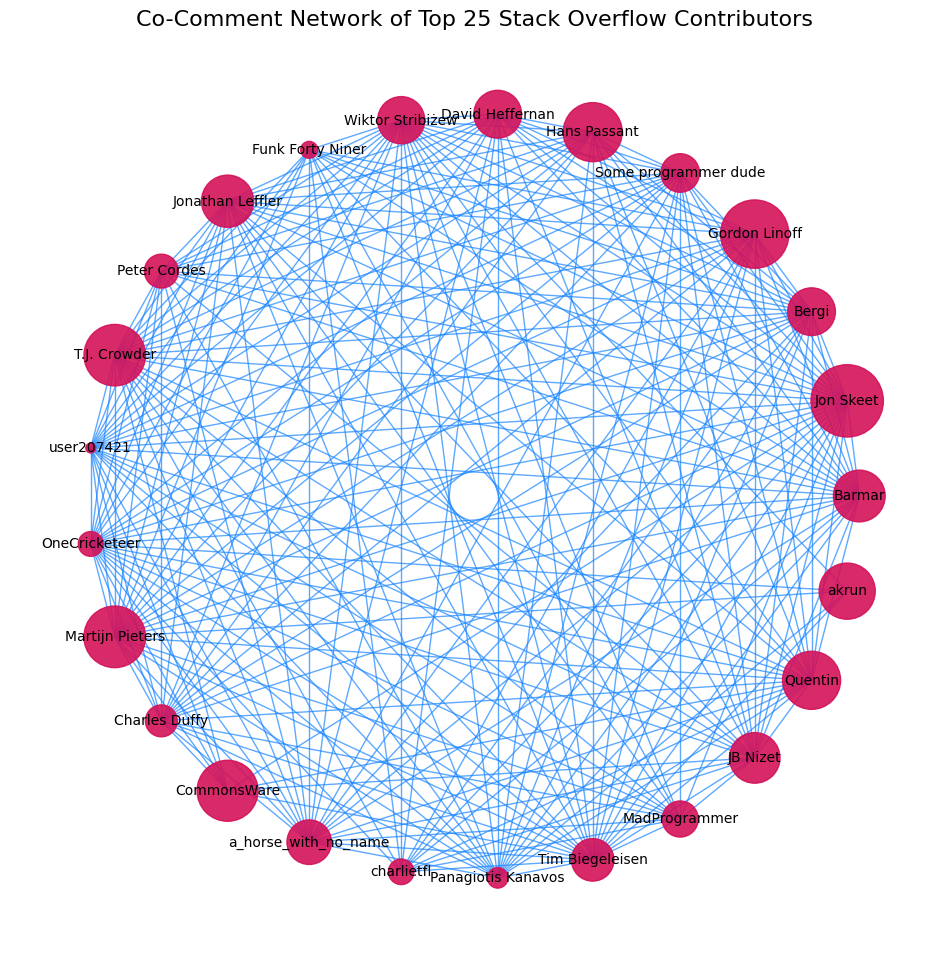

In [11]:
G = nx.Graph()

# Add nodes with attributes (label and reputation)
for _, row in top_users.iterrows():
    G.add_node(
        row['User ID'], 
        label=row['Display Name'],
        reputation=row['Reputation']
    )

# Add edges 
G.add_edges_from(edges)

reputations = [G.nodes[node]['reputation'] for node in G.nodes()]
node_sizes = [max(rep / 500, 50) for rep in reputations]  # scale and avoid zero size

plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)

# Draw nodes, scaling by reputation
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color="#D41159",
    alpha=0.9
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    width=1,
    alpha=0.7,
    edge_color="#1A85FF"
)

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    labels=nx.get_node_attributes(G, 'label'),
    font_size=10
)

plt.title("Co-Comment Network of Top 25 Stack Overflow Contributors", fontsize=16)
plt.axis('off')
plt.show()
